In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.metrics import roc_auc_score , accuracy_score , precision_score, recall_score ,confusion_matrix
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle
import h5py
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

%matplotlib inline

In [2]:
BASE_DIR = os.getcwd()

In [3]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv('Epileptic Seizure Recognition.csv')

In [5]:
data.head()

,Unnamed,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


In [6]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
count,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.00000,11500.00000,11500.000000,...,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000,11500.000000
mean,-11.581391,-10.911565,-10.187130,-9.143043,-8.009739,-7.003478,-6.502087,-6.68713,-6.55800,-6.168435,...,-10.145739,-11.630348,-12.943478,-13.668870,-13.363304,-13.045043,-12.705130,-12.426000,-12.195652,3.000000
std,165.626284,166.059609,163.524317,161.269041,160.998007,161.328725,161.467837,162.11912,162.03336,160.436352,...,164.652883,166.149790,168.554058,168.556486,167.257290,164.241019,162.895832,162.886311,164.852015,1.414275
min,-1839.000000,-1838.000000,-1835.000000,-1845.000000,-1791.000000,-1757.000000,-1832.000000,-1778.00000,-1840.00000,-1867.000000,...,-1867.000000,-1865.000000,-1642.000000,-1723.000000,-1866.000000,-1863.000000,-1781.000000,-1727.000000,-1829.000000,1.000000
25%,-54.000000,-55.000000,-54.000000,-54.000000,-54.000000,-54.000000,-54.000000,-55.00000,-55.00000,-54.000000,...,-55.000000,-56.000000,-56.000000,-56.000000,-55.000000,-56.000000,-55.000000,-55.000000,-55.000000,2.000000
50%,-8.000000,-8.000000,-7.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.00000,-7.00000,-7.000000,...,-9.000000,-10.000000,-10.000000,-10.000000,-10.000000,-9.000000,-9.000000,-9.000000,-9.000000,3.000000
75%,34.000000,35.000000,36.000000,36.000000,35.000000,36.000000,35.000000,36.00000,36.00000,35.250000,...,34.000000,34.000000,33.000000,33.000000,34.000000,34.000000,34.000000,34.000000,34.000000,4.000000
max,1726.000000,1713.000000,1697.000000,1612.000000,1518.000000,1816.000000,2047.000000,2047.00000,2047.00000,2047.000000,...,1777.000000,1472.000000,1319.000000,1436.000000,1733.000000,1958.000000,2047.000000,2047.000000,1915.000000,5.000000


In [7]:
data.shape

(11500, 180)

### Visualization

In [8]:
data.describe(include=object)

,Unnamed
count,11500
unique,11500
top,X21.V1.791
freq,1


In [9]:
null_values = data.isnull().sum()
null_values.to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [10]:
# c=list(data['Unnamed'])
#
# d1 = [x.split('.')[0] for x in c]
# d1 = set(d1)
# print('D1 Len',len(d1))
# print('D1',d1)
#
# d2 = [x.split('.')[1] for x in c]
# d2 = set(d2)
# print('D2 Len',len(d2))
# print('D2',d2)
#
# d3 = [x.split('.')[-1] for x in c]
# d3 = set(d3)
# print('D3 Len',len(d3))

In [11]:
data_1 = data.copy()

In [12]:
data_1.drop(['Unnamed','y'],axis=1,inplace=True)

In [13]:
data_1

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,135,190,229,223,192,125,55,-9,-33,-38,...,8,-17,-15,-31,-77,-103,-127,-116,-83,-51
1,386,382,356,331,320,315,307,272,244,232,...,168,164,150,146,152,157,156,154,143,129
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,29,57,64,48,19,-12,-30,-35,-35,-36
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-80,-82,-81,-80,-77,-85,-77,-72,-69,-65
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,10,4,2,-12,-32,-41,-65,-83,-89,-73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11495,-22,-22,-23,-26,-36,-42,-45,-42,-45,-49,...,20,15,16,12,5,-1,-18,-37,-47,-48
11496,-47,-11,28,77,141,211,246,240,193,136,...,-94,-65,-33,-7,14,27,48,77,117,170
11497,14,6,-13,-16,10,26,27,-9,4,14,...,-42,-65,-48,-61,-62,-67,-30,-2,-1,-8
11498,-40,-25,-9,-12,-2,12,7,19,22,29,...,114,121,135,148,143,116,86,68,59,55


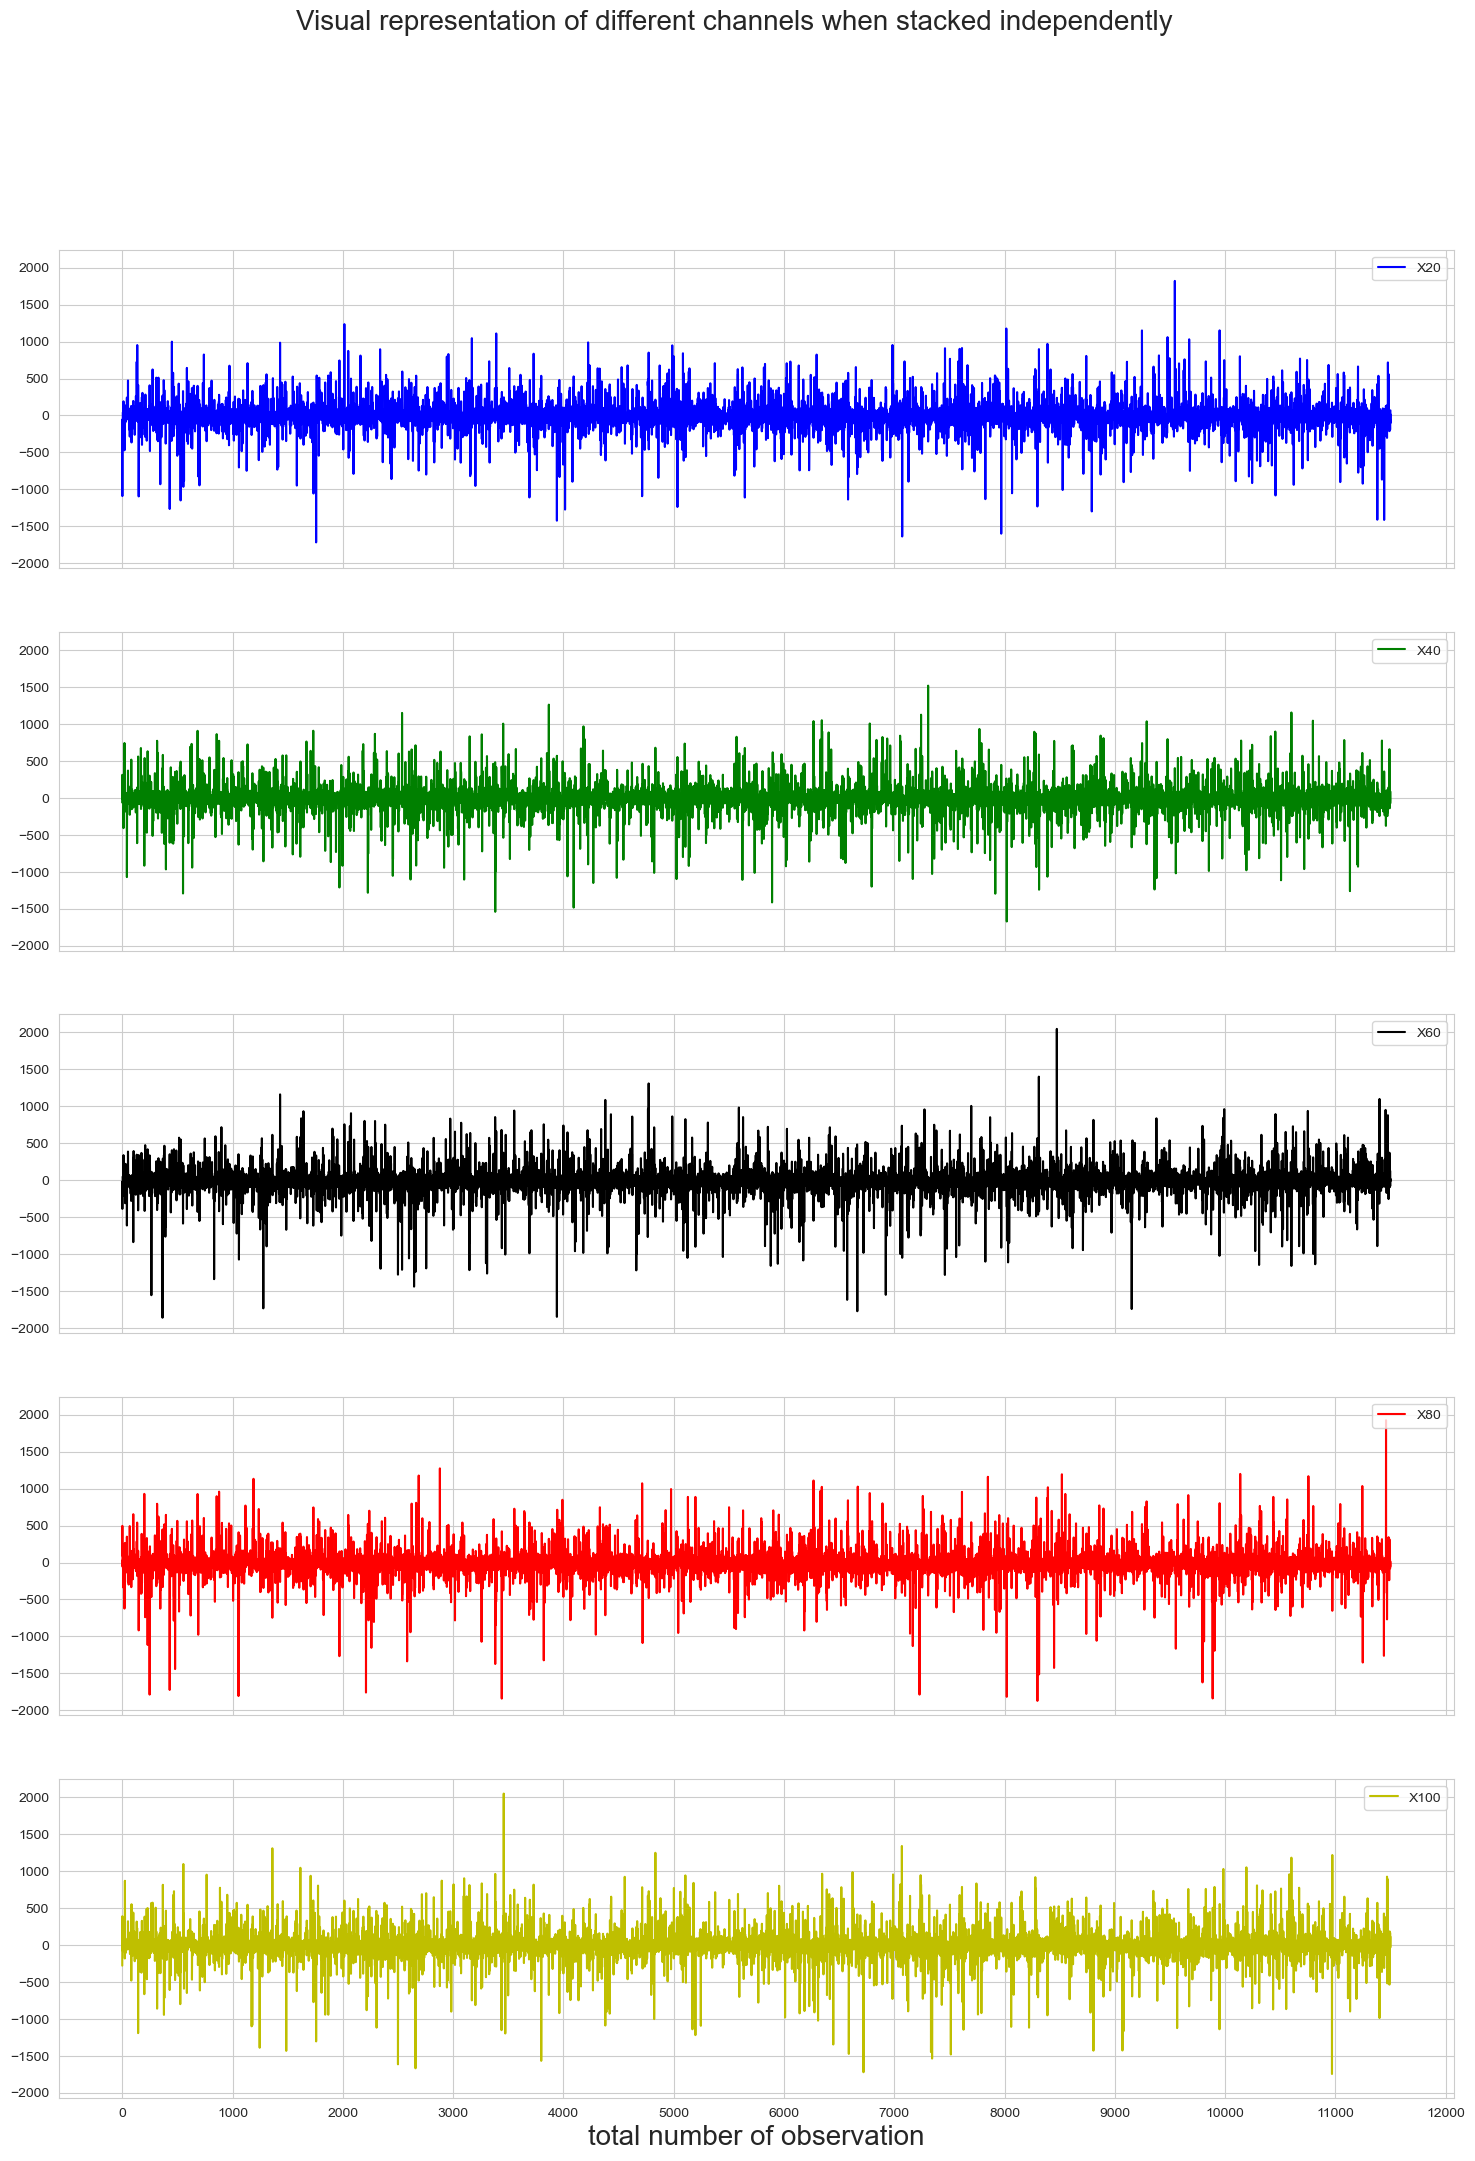

In [14]:
fig, axs = plt.subplots(5, sharex=True, sharey=True)
fig.set_size_inches(18, 24)
labels = ["X20","X40","X60","X80","X100"]
colors = ["b","g","k","r","y"]
fig.suptitle('Visual representation of different channels when stacked independently', fontsize = 20)
for i,ax in enumerate(axs):
  axs[i].plot(data.iloc[:,0],data[labels[i]],color=colors[i],label=labels[i])
  axs[i].legend(loc="upper right")


plt.xlabel('total number of observation', fontsize = 20)
x_ticks = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000]
x_ticklabels = ['0', '1000', '2000', '3000', '4000', '5000', '6000', '7000', '8000', '9000', '10000', '11000', '12000']
plt.xticks(x_ticks, x_ticklabels)
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img', 'independent_channel.png'))
plt.show()

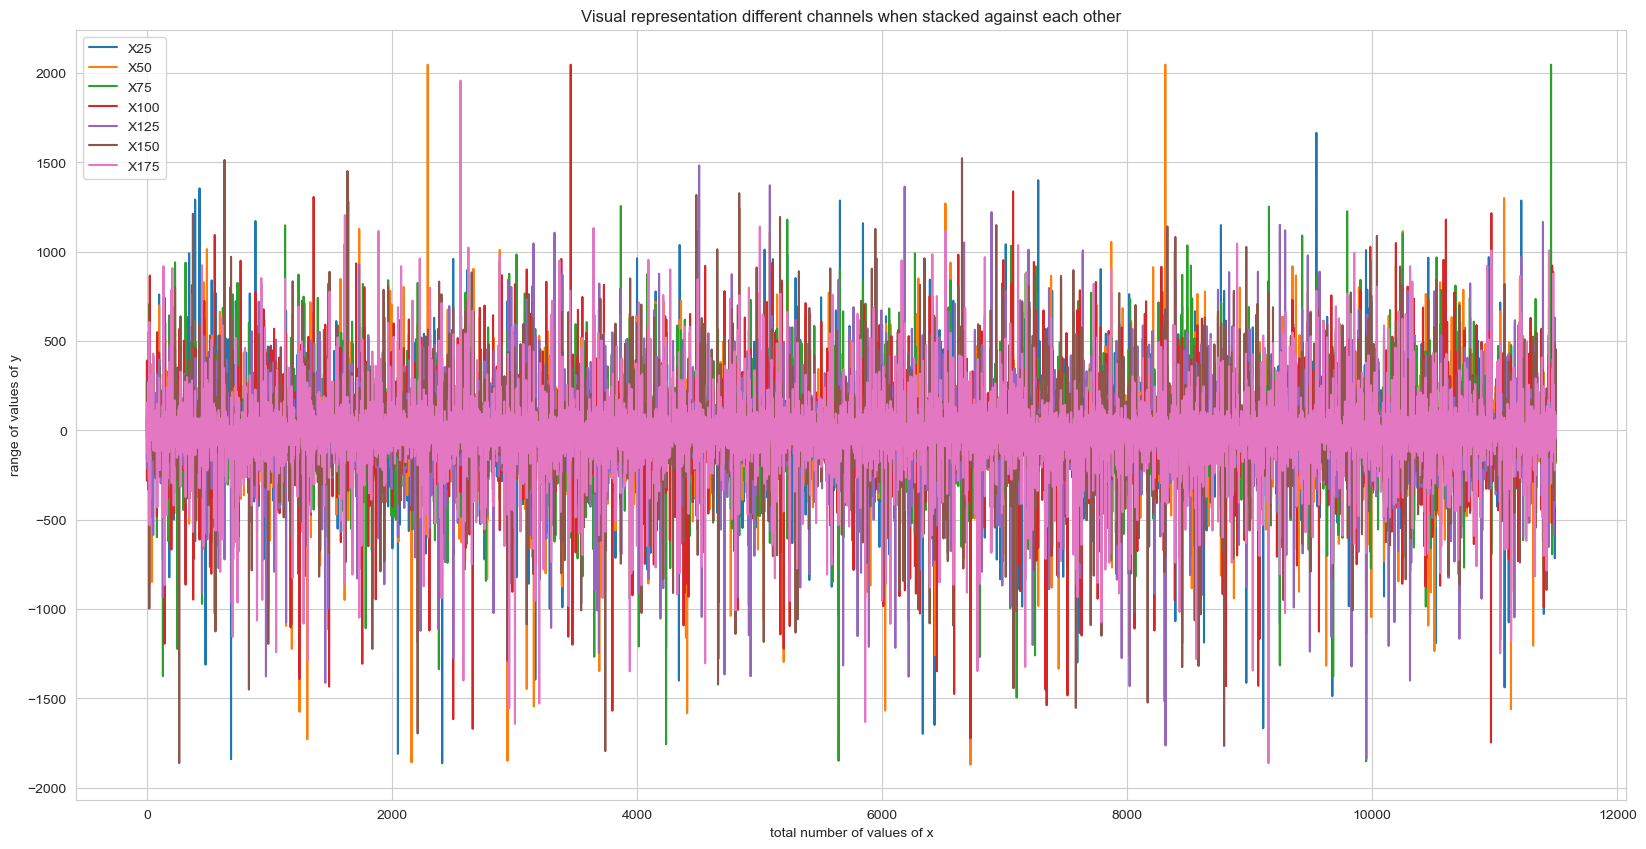

In [15]:
plt.rcParams["figure.figsize"] = (20, 10)
data.loc[:,::25].plot()
plt.title("Visual representation different channels when stacked against each other")
plt.xlabel("total number of values of x")
plt.ylabel("range of values of y")
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img', 'stacked_channels.png'))
plt.show()

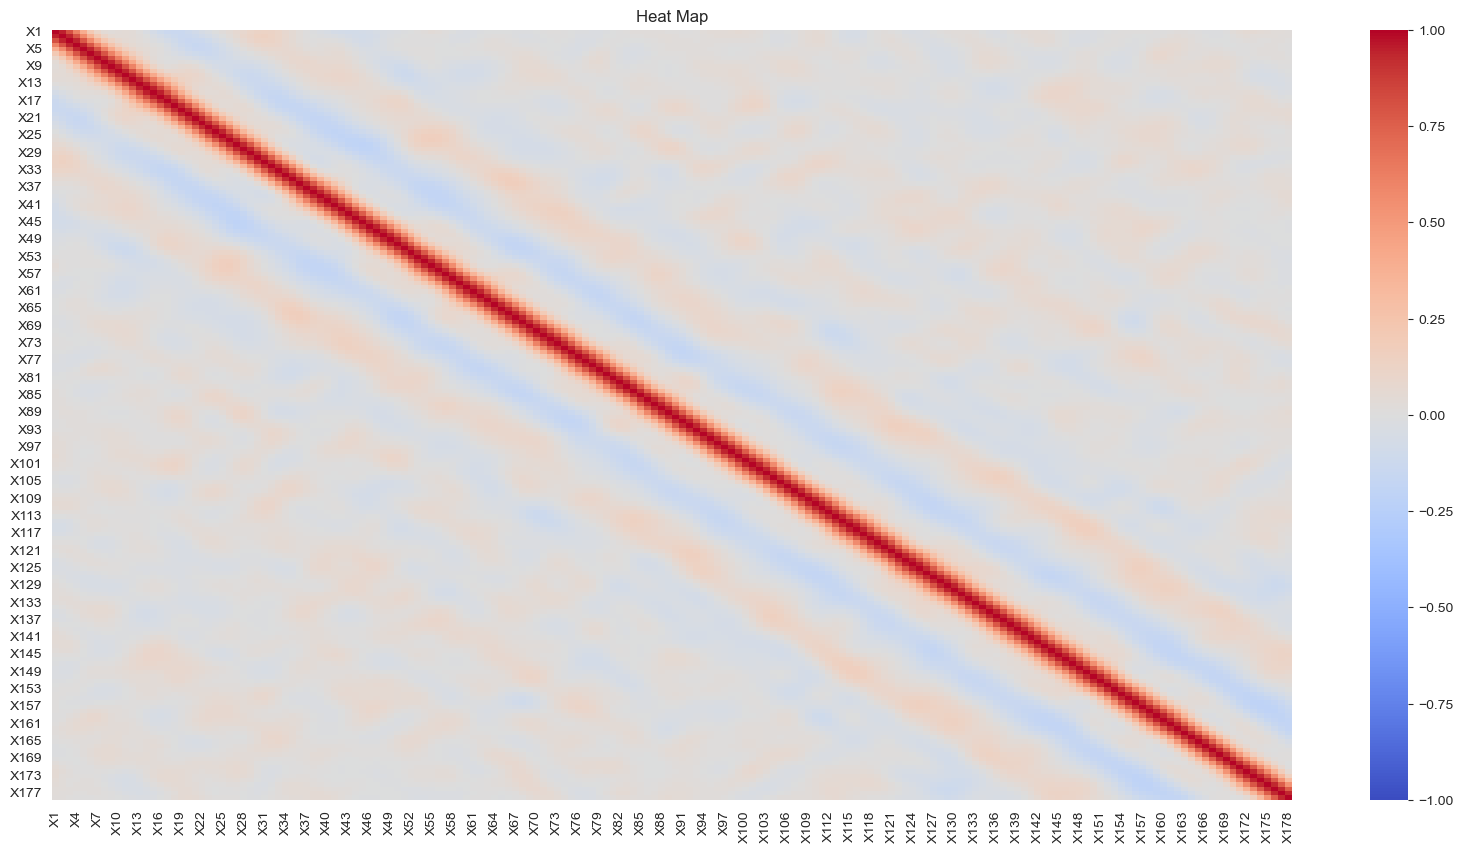

In [16]:
corr = data_1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap='coolwarm'
)
plt.title("Heat Map")
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img','heat_map.png'))
plt.show()

### Solve Class Imbalance

In [17]:
data_2 = data.drop(["Unnamed"],axis=1).copy()

In [18]:
data_2["Output"]= data_2.y == 0

In [19]:
data_2["Output"] = data_2["Output"].astype(int)

In [20]:
data_2.y.value_counts()

4    2300
1    2300
5    2300
2    2300
3    2300
Name: y, dtype: int64

In [21]:
data_2['y'] = data_2['y'].replace([2,3,4,5],0)

In [22]:
data_2.y.value_counts()

0    9200
1    2300
Name: y, dtype: int64

In [23]:
data_2.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X171,X172,X173,X174,X175,X176,X177,X178,y,Output
0,135,190,229,223,192,125,55,-9,-33,-38,...,-15,-31,-77,-103,-127,-116,-83,-51,0,0
1,386,382,356,331,320,315,307,272,244,232,...,150,146,152,157,156,154,143,129,1,0
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,64,48,19,-12,-30,-35,-35,-36,0,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-81,-80,-77,-85,-77,-72,-69,-65,0,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,2,-12,-32,-41,-65,-83,-89,-73,0,0


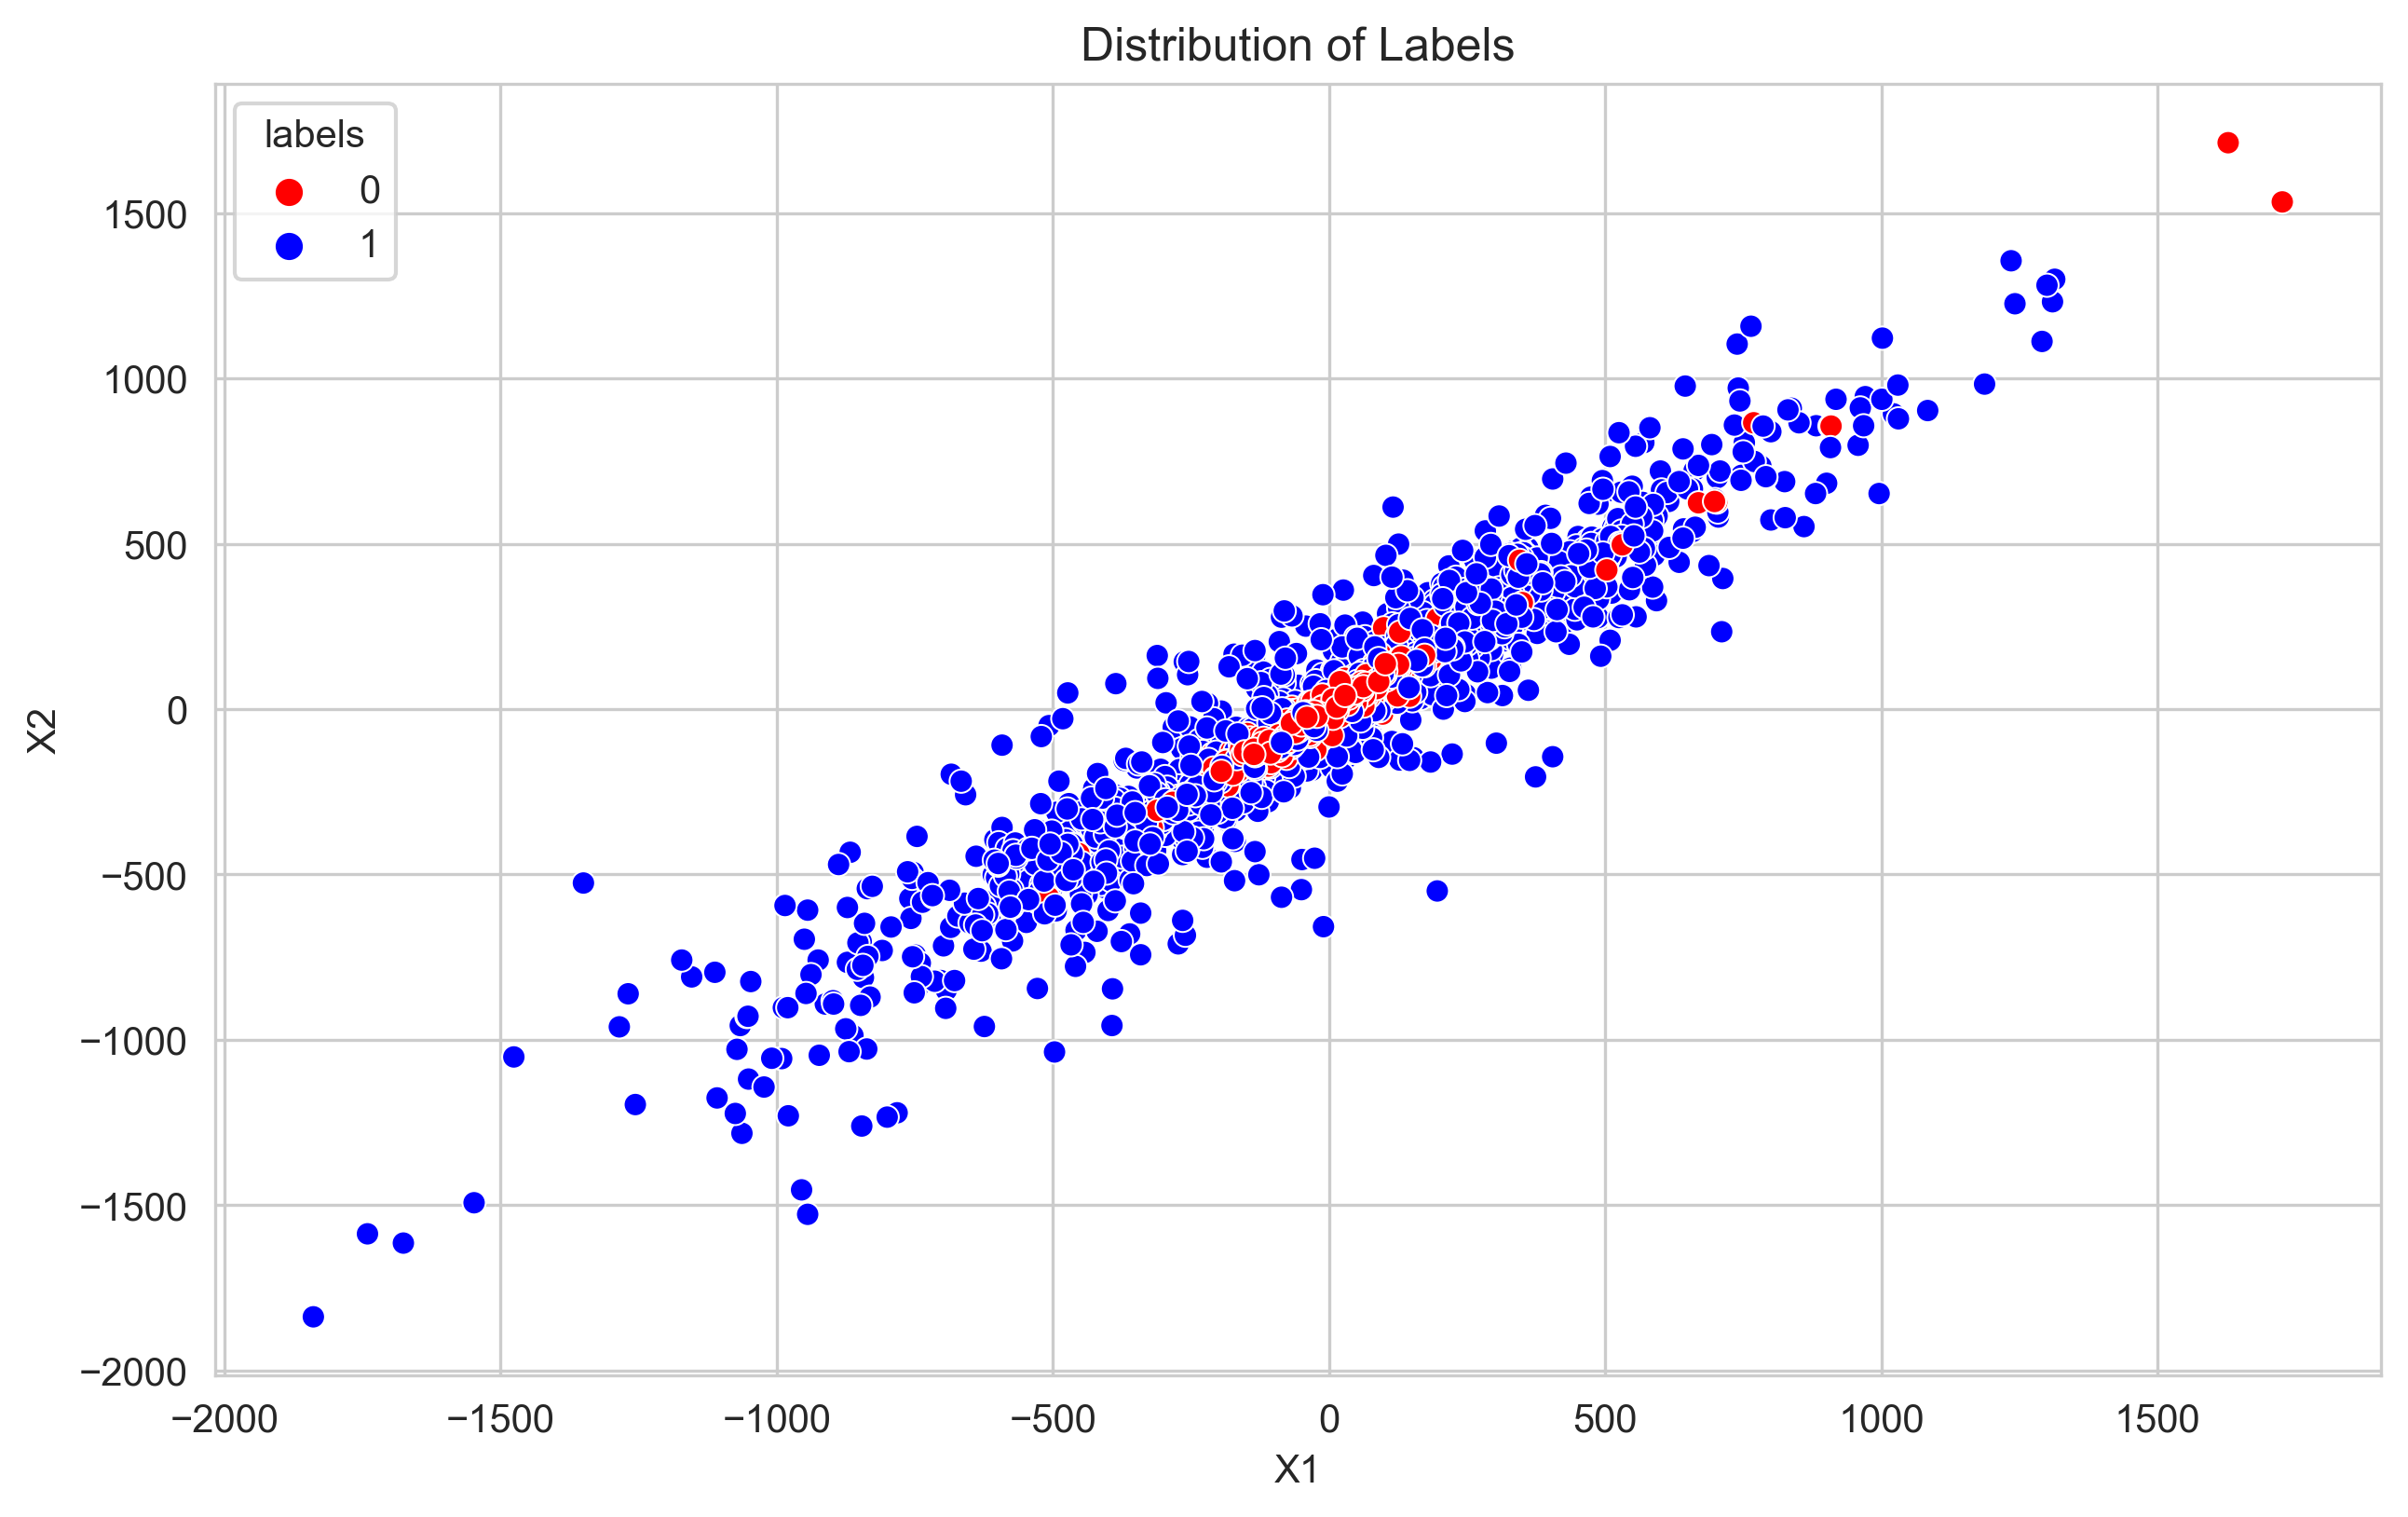

In [24]:
plt.figure(figsize=(10,6),dpi=300)
sns.despine(left=True)
sns.scatterplot(x='X1', y='X2', hue = 'y', data=data_2, palette=['red', 'blue'])
plt.title('Distribution of Labels')
plt.legend(loc='upper left', title="labels")
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img', 'scatter_plot.png'))
plt.show()

In [25]:
data_2.y.value_counts()

0    9200
1    2300
Name: y, dtype: int64

In [26]:
X  = data_2.drop(['Output','y'], axis=1)
y = data_2['y']

In [27]:
counter = Counter(y)
print('Before',counter)
smenn = SMOTEENN()
X_train1, y_train1 = smenn.fit_resample(X, y)
counter = Counter(y_train1)
print('After',counter)

Before Counter({0: 9200, 1: 2300})
After Counter({0: 9068, 1: 9068})


In [66]:
# Save data for using in Django
X_train1.to_csv(os.path.join(BASE_DIR, 'data', 'data.csv'), index=False)
y_train1.to_csv(os.path.join(BASE_DIR,'data', 'labels.csv'), index=False)

### Train/Test/Validation Dataset Splitting


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_train1,y_train1,test_size=0.2,random_state=42)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.25,random_state=42)

### Feature Scaling

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [32]:
print(f"The shape of the training set is :{X_train.shape}")
print(f"The shape of the testing set is :{X_test.shape}")
print(f"The shape of the validation set is :{X_val.shape}")

The shape of the training set is :(10881, 178)
The shape of the testing set is :(3628, 178)
The shape of the validation set is :(3627, 178)


### Logistic Regression

In [33]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [34]:
# Save Logistic Regression Model
lg_filename = 'LogisticRegressionModel.pickle'
with open(os.path.join(BASE_DIR, "model", lg_filename), 'wb') as f:
    pickle.dump(logreg, f)

In [35]:

y_pred = logreg.predict(X_val)
print(f"The accuracy score of the model on the validation data is:{metrics.accuracy_score(y_val, y_pred)*100:.2f}.")

The accuracy score of the model on the validation data is:63.39.


In [36]:
models_dataframe = pd.DataFrame({
    'Model': ['Logistic Regression'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['LogisticView']
})

In [37]:
logit_fpr, logit_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
logit_auc = metrics.roc_auc_score(y_val, y_pred)

### KNN

In [38]:
pipe = Pipeline([('knn', KNeighborsClassifier())])
param_grid = {'knn__n_neighbors': [9,10, 100]}
knn = GridSearchCV(pipe, param_grid, cv=5)

knn.fit(X_train,y_train)
print('Best hyperparameters:', knn.best_params_)
# Save KNN Model
knn_filename = 'KNNModel.pickle'
with open(os.path.join(BASE_DIR, "model", knn_filename), 'wb') as f:
    pickle.dump(knn, f)

Best hyperparameters: {'knn__n_neighbors': 9}


In [39]:
y_pred = knn.predict(X_val)
knn_fpr, knn_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
knn_auc = metrics.roc_auc_score(y_val, y_pred)
y_valid_preds = knn.predict_proba(X_val)
precision = metrics.accuracy_score(y_pred=y_pred, y_true=y_val) * 100
print(f"Accuracy with K-NN: {precision:.2f}%")

Accuracy with K-NN: 96.47%


In [40]:
new_row = pd.DataFrame({
    'Model': ['KNN'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['KNNView']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### Support Vector Machine

In [41]:
clf = svm.SVC(kernel='poly', C=100, gamma=0.01, probability=True)
clf.fit(X_train, y_train)


SVC(C=100, gamma=0.01, kernel='poly', probability=True)

In [42]:
# Save SVM Model
svm_filename = 'SVMModel.pickle'
with open(os.path.join(BASE_DIR, "model", svm_filename), 'wb') as f:
    pickle.dump(clf, f)

In [43]:
y_pred = clf.predict(X_val)
precision = metrics.accuracy_score(y_pred=y_pred, y_true=y_val) * 100
print(f"Accuracy with SVM: {precision:.2f}%")
probs = clf.predict_proba(X_val)
probs = probs[:, 1]
svm_fpr, svm_tpr, thresholds = metrics.roc_curve(y_val, probs)
svm_auc = metrics.roc_auc_score(y_val, probs)

Accuracy with SVM: 93.96%


In [44]:
new_row = pd.DataFrame({
    'Model': ['SVM'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['SVMView']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### Naive Bayes Classifier

In [45]:
naive = GaussianNB()
naive.fit(X_train,y_train)
# Save NaiveBayes Model
nb_filename = 'NaiveBayesModel.pickle'
with open(os.path.join(BASE_DIR, "model", nb_filename), 'wb') as f:
    pickle.dump(naive, f)


In [46]:
y_pred = naive.predict(X_val)
naive_fpr, naive_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
naive_auc = metrics.roc_auc_score(y_val, y_pred)
print(f'Accuracy with naive is:{metrics.accuracy_score(y_pred=y_pred, y_true=y_val) * 100:.2f}%.')

Accuracy with naive is:91.32%.


In [47]:
new_row = pd.DataFrame({
    'Model': ['Naive Bayes'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['NaiveBayesView']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### Random Forest Classifier

In [48]:
random = RandomForestClassifier(max_depth=10,random_state=69)
random.fit(X_train,y_train)

# Save RF Model
rf_filename = 'RandomForestModel.pickle'
with open(os.path.join(BASE_DIR, "model", rf_filename), 'wb') as f:
    pickle.dump(random, f)


In [49]:
#predicting
y_pred = random.predict(X_val)
random_fpr, random_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
random_auc = metrics.roc_auc_score(y_val, y_pred)
#Evaluating the model
precision = metrics.accuracy_score(y_pred=y_pred,y_true=y_val)* 100
#print  the accuracy
print(f"Accuracy of the model by using the random forest algorithm : {precision:.2f}%")

Accuracy of the model by using the random forest algorithm : 96.55%


In [50]:
new_row = pd.DataFrame({
    'Model': ['Random Forest'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['RandomForestView']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### XgBoost

In [51]:
xgbc = XGBClassifier()

xgbc.fit(X_train,y_train)

# Save SVM Model
xg_filename = 'XgBoostModel.pickle'
with open(os.path.join(BASE_DIR, "model", xg_filename), 'wb') as f:
    pickle.dump(xgbc, f)

In [52]:
#predicting
y_pred = xgbc.predict(X_val)
xgbc_fpr, xgbc_tpr, thresholds = metrics.roc_curve(y_val, y_pred)
xgbc_auc = metrics.roc_auc_score(y_val, y_pred)
#Evaluating the model
precision = metrics.accuracy_score(y_pred=y_pred,y_true=y_val)* 100
#print  the accuracy
print(f"Accuracy of the model by using the xgbc algorithm : {precision:.2f}%")

Accuracy of the model by using the xgbc algorithm : 98.29%


In [53]:
new_row = pd.DataFrame({
    'Model': ['XgBoost'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred)*100:.2f}'],
    'Precision': [f'{metrics.precision_score(y_val, y_pred)*100:.2f}'],
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred)*100:.2f}'],
    'Recall': [f'{metrics.recall_score(y_val, y_pred)*100:.2f}'],
    'View': ['XgBoostView']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

### ROC Curve

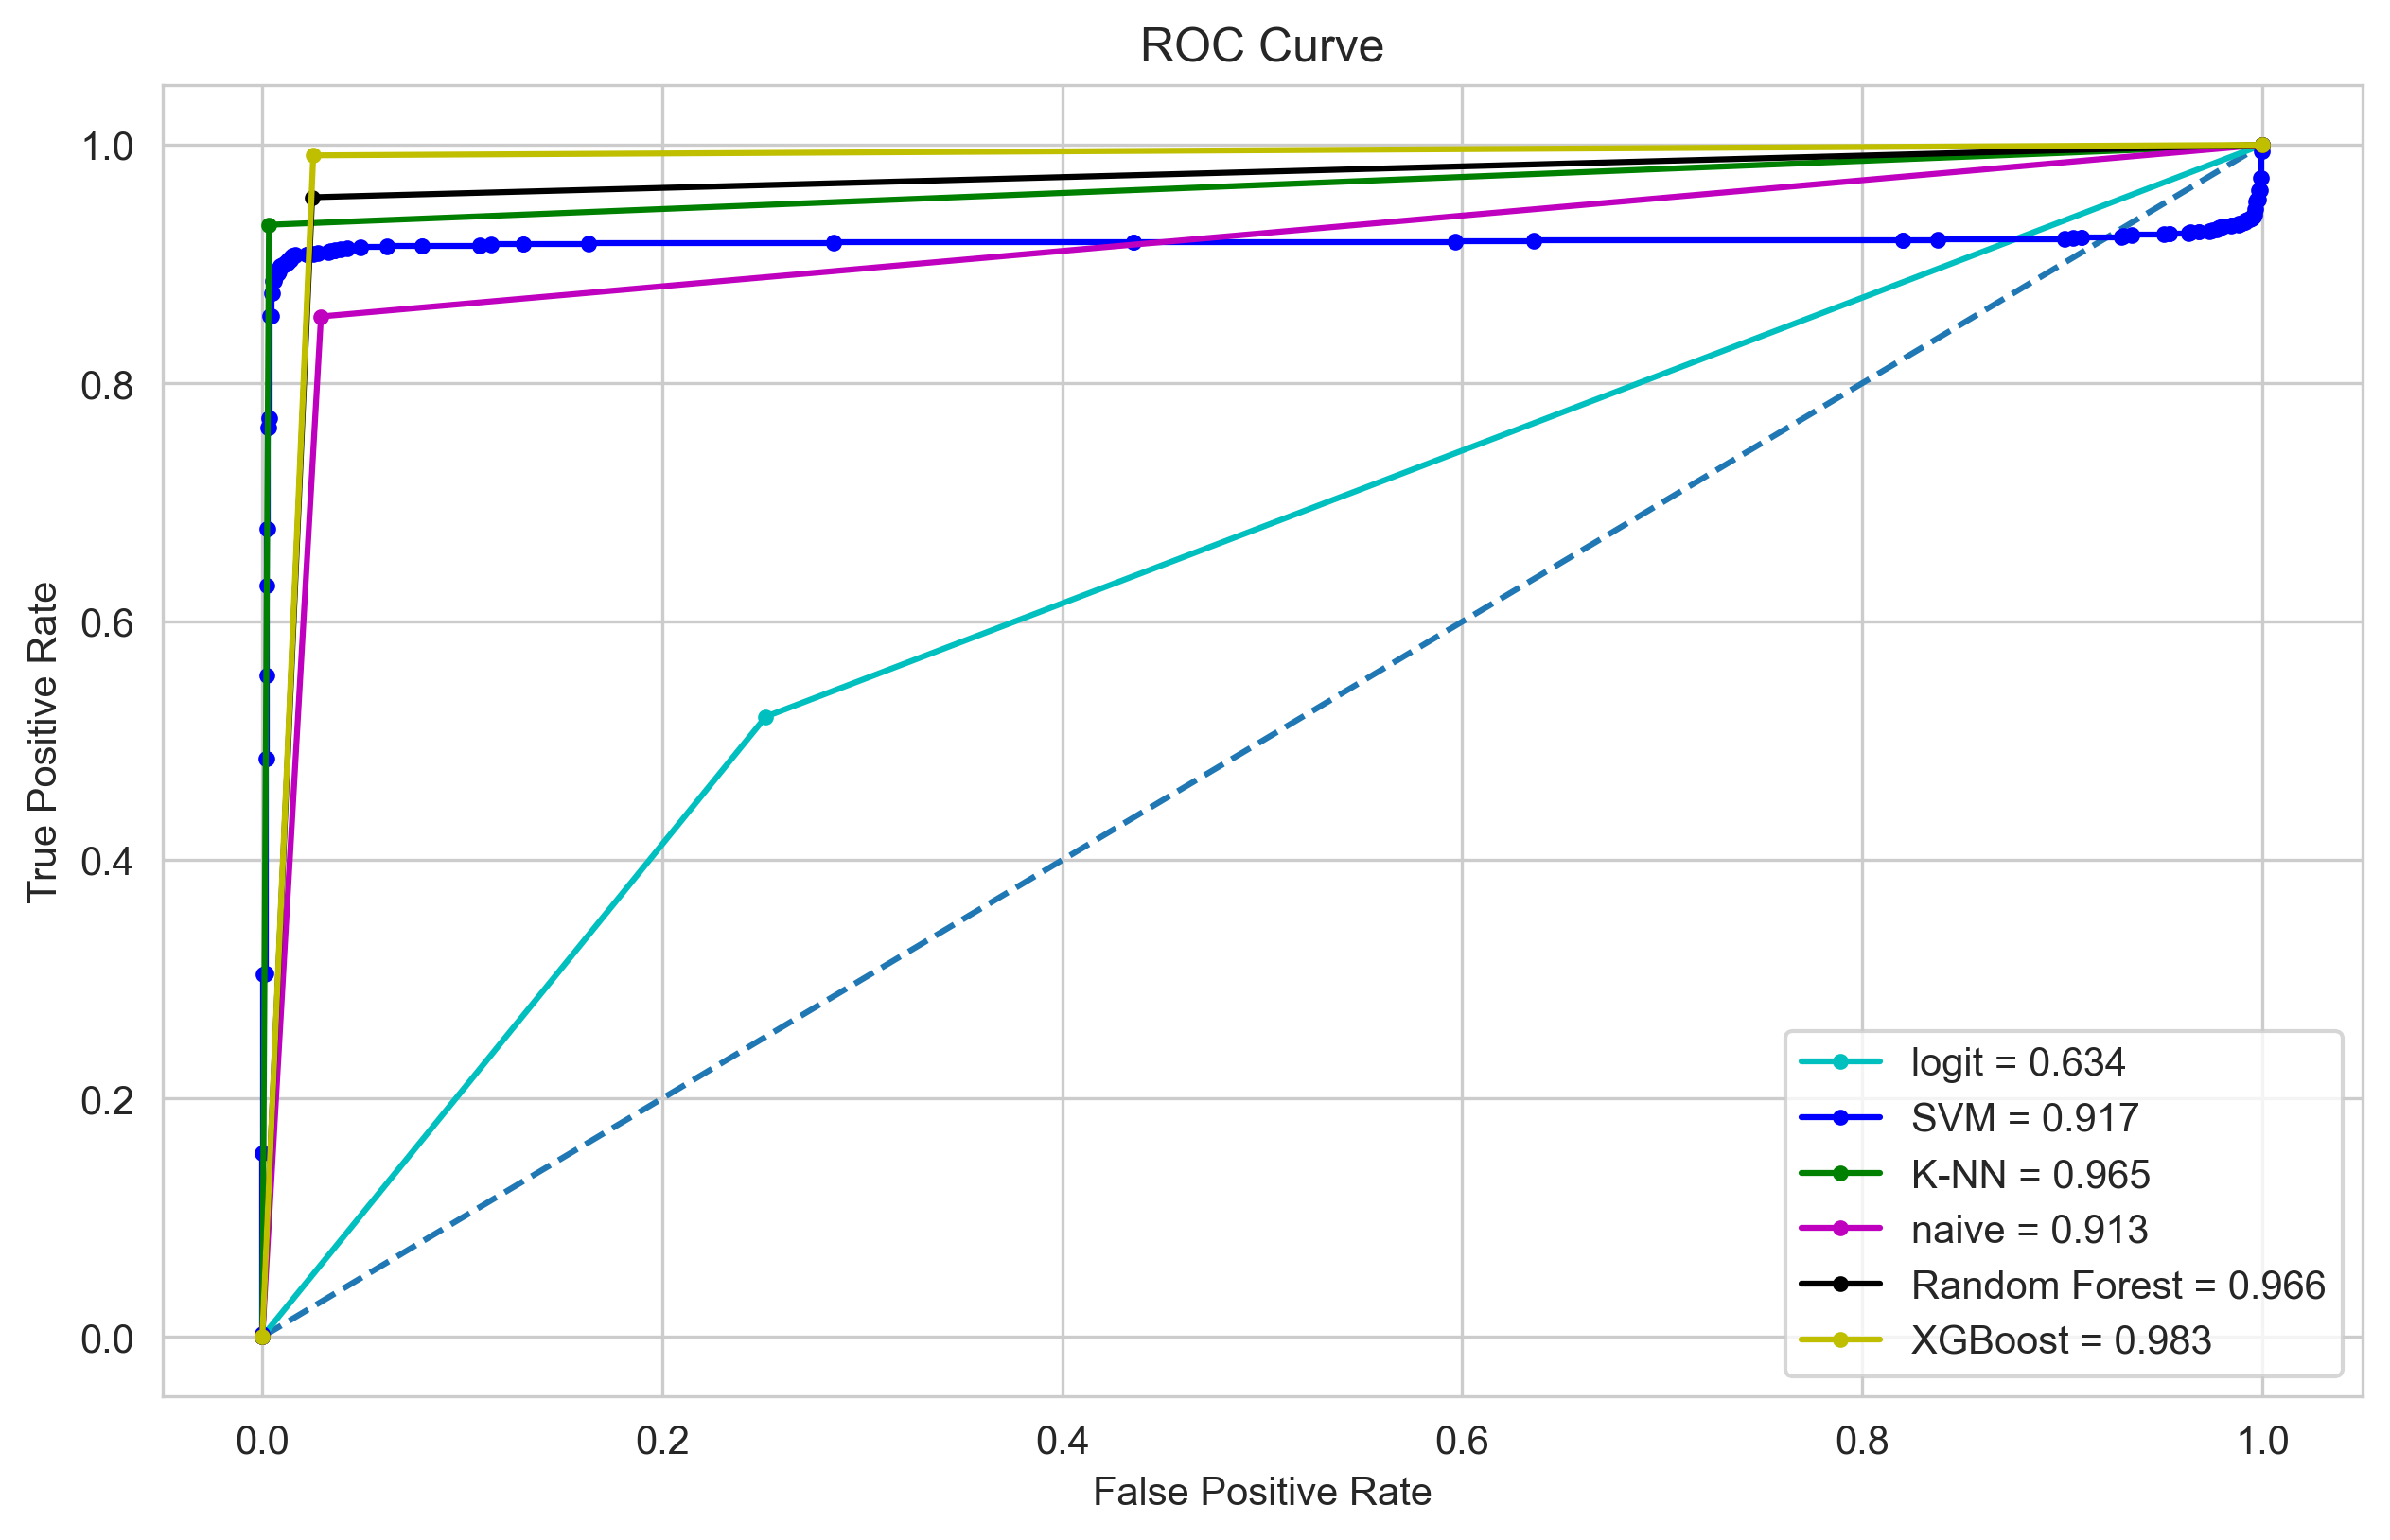

In [54]:
plt.figure(figsize=(10,6),dpi=300)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(logit_fpr, logit_tpr, 'c', marker='.', label = 'logit = %0.3f' % logit_auc )
plt.plot(svm_fpr, svm_tpr, 'b', marker='.', label = 'SVM = %0.3f' % svm_auc )
plt.plot(knn_fpr, knn_tpr, 'g', marker='.', label = 'K-NN = %0.3f' % knn_auc)
plt.plot(naive_fpr, naive_tpr, 'm', marker='.', label = 'naive = %0.3f' % naive_auc)
plt.plot(random_fpr, random_tpr, 'k', marker='.',label = 'Random Forest = %.3f' % random_auc)
plt.plot(xgbc_fpr, xgbc_tpr, 'y', marker='.',label = 'XGBoost = %.3f' % xgbc_auc)


plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig(os.path.join(BASE_DIR, 'static/assets/img', 'roc_curve.png'), dpi=100)
plt.show()

### Deep Learning

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall

In [56]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,
    patience=20,
    restore_best_weights=True
)

In [57]:
model1 = Sequential()
model1.add(layers.Reshape((178, 1, 1), input_shape=(178,)))
model1.add(layers.Conv2D(filters=32, kernel_size=(10, 1), activation='relu', input_shape=(178, 1, 1)))
model1.add(layers.MaxPooling2D(pool_size=(3, 1)))
model1.add(layers.Conv2D(filters=64, kernel_size=(10, 1), activation='relu'))
model1.add(layers.MaxPooling2D(pool_size=(3, 1)))
model1.add(layers.Flatten())
model1.add(layers.Dense(units=64, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(units=1, activation='sigmoid'))

# model Summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 178, 1, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 169, 1, 32)        352       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 1, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 1, 64)         20544     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 1, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 960)               0

In [58]:
# Compile the model
model1.compile(loss='binary_crossentropy',
               optimizer=Adam(learning_rate=0.001),
               metrics=['accuracy',  Precision(), Recall()])


# Train the model
history = model1.fit(X_train, y_train,
                     epochs=500,
                     batch_size=32,
                     validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/500
341/341 [==============================] - 7s 9ms/step - loss: 0.1842 - accuracy: 0.9238 - precision: 0.9050 - recall: 0.9476 - val_loss: 0.1082 - val_accuracy: 0.9586 - val_precision: 0.9399 - val_recall: 0.9802
Epoch 2/500
341/341 [==============================] - 3s 8ms/step - loss: 0.1035 - accuracy: 0.9653 - precision: 0.9657 - recall: 0.9650 - val_loss: 0.0866 - val_accuracy: 0.9677 - val_precision: 0.9808 - val_recall: 0.9544
Epoch 3/500
341/341 [==============================] - 3s 8ms/step - loss: 0.0833 - accuracy: 0.9716 - precision: 0.9744 - recall: 0.9688 - val_loss: 0.0774 - val_accuracy: 0.9722 - val_precision: 0.9614 - val_recall: 0.9841
Epoch 4/500
341/341 [==============================] - 3s 8ms/step - loss: 0.0644 - accuracy: 0.9766 - precision: 0.9778 - recall: 0.9754 - val_loss: 0.1019 - val_accuracy: 0.9653 - val_precision: 0.9862 - val_recall: 0.9440
Epoch 5/500
341/341 [==============================] - 3s 8ms/step - loss: 0.0678 - accuracy: 0.9773

In [59]:
model1.save(os.path.join(BASE_DIR, 'model', 'DeepLearning.h5'))

In [60]:
# Evaluate the model on the data
test_loss, test_acc, test_precision, test_recall = model1.evaluate(X_test, y_test)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

114/114 [==============================] - 1s 5ms/step - loss: 0.0355 - accuracy: 0.9895 - precision: 0.9894 - recall: 0.9894
Test loss: 0.03549813851714134
Test accuracy: 0.9895259141921997


In [61]:
predictions = model1.predict(X_val)
print("Predictions",predictions)

Predictions [[2.3394391e-04]
 [6.5112673e-04]
 [9.9974746e-01]
 ...
 [2.3245599e-04]
 [9.9995959e-01]
 [7.5393273e-06]]


In [62]:
# Convert predictions to binary class labels
y_pred_labels = [1 if x > 0.5 else 0 for x in predictions]

In [63]:
new_row = pd.DataFrame({
    'Model': ['CNN'],
    'Score': [f'{metrics.accuracy_score(y_val, y_pred_labels)*100:.2f}'],
    'Precision': f'{test_precision*100:.2f}',
    'F1_Score': [f'{metrics.f1_score(y_val, y_pred_labels)*100:.2f}'],
    'Recall': f'{test_recall*100:.2f}',
    'View': ['CNNView']
})
if not models_dataframe.isin(new_row).all().all():
    # If the new row values do not exist in the DataFrame, append the row
    models_dataframe = models_dataframe.append(new_row, ignore_index=True)

In [64]:
print(models_dataframe.sort_values('Score', ascending=False))

                 Model  Score Precision F1_Score Recall              View
6                  CNN  98.54     98.94    98.55  98.94           CNNView
5              XgBoost  98.29     97.51    98.31  99.12       XgBoostView
4        Random Forest  96.55     97.48    96.53  95.60  RandomForestView
1                  KNN  96.47     99.65    96.37  93.30           KNNView
2                  SVM  93.96     99.44    93.63  88.46           SVMView
3          Naive Bayes  91.32     96.71    90.82  85.60    NaiveBayesView
0  Logistic Regression  63.39     67.55    58.78  52.03      LogisticView


In [65]:
models_dataframe.sort_values('Score', ascending=False).to_csv(os.path.join(BASE_DIR, 'data', 'model_acc_dataframe.csv'), index=False)